#### Setup

In [7]:
%load_ext autoreload

In [8]:
%autoreload 2

In [9]:
import time
import ctypes
import xarray as xr
import geopandas as gpd
import numpy as np

import aggfly
from aggfly import regions, grid_weights, dataset
from aggfly.aggregate import TemporalAggregator, SpatialAggregator

import dask
from dask.distributed import Client
from dask.diagnostics import ProgressBar
from dask.cache import Cache

cache = Cache(10e9)  # Leverage two gigabytes of memory
cache.register()    # Turn cache on globally

ProgressBar().register()

In [10]:
# Set file output name/path
project_dir = '/home3/dth2133/data/clim-data-compare/era5'
output_path = "/home3/dth2133/data/aggregated/counties/"
output_name = "usa_counties_corn_monthly"
output_varn = "dd"
csv = True

#### Define aggregation parameters

These objects describe the spatial and temporal aggregation operations.

In [33]:
# Open shapefile containing region features.
georegions = regions.from_name('counties')

# Years to aggregate
years = np.arange(2018,2019)

# This object aggregates cells within a region to the average across 
# cells, weighted by `weights`, which in this case are the area of the
# cell and the share of the cell with corn crops.
spatial = SpatialAggregator('avg')

temps = range(-4,41)
# This object covers aggregating hourly and daily data to the yearly 
# level
daily = (
    [TemporalAggregator(
        'dd',
        agg_from='hour',
        agg_to='day', 
        ddargs=[x,999,0]) for x in temps] +
    [TemporalAggregator(
        'time',
        agg_from='hour',
        agg_to='day', 
        ddargs=[x,999,0]) for x in temps] 
)

monthly = TemporalAggregator(
    'sum', 
    agg_from='day',
    agg_to='month')

#### Calculate Weights

In [18]:
# Open example climate dataset to calculate grid weights.
clim = dataset.from_path( 
    f"/home3/dth2133/data/usa/usa-t2m_tempPrecLand2019.zarr", 
    't2m', 
    'zarr', 
    preprocess=dataset.timefix_era5l,
    name='era5')

# Clip climate data to the US (raw data are global)
clim.clip_data_to_georegions_extent(georegions)

# Rechunk dataset to optimize multithreading
clim.rechunk('auto')

# Calculate area and crop layer weights.
weights = grid_weights.from_objects(
    clim,
    georegions,
    crop='corn',
    name='cropland',
    project_dir=project_dir
)

In [19]:
# Calculate the grid weights

# Loading from disk to save a couple minutes
# w.rename('weights').to_dataset().to_netcdf('CILads_testweights.nc')
# w = xr.open_dataset('CILads_testweights.nc')['weights']

# Usually do this!
w = weights.weights()
# w = w.chunk((-1))

Loading rescaled corn weights from cache
Loading rescaled weights from cache


In [20]:
w

<xarray.DataArray 'multiply-28e9b29ad9256297ea7f295adae72509' (region: 3108, latitude: 250, longitude: 578)>
dask.array<xarray-<this-array>, shape=(3108, 250, 578), dtype=float64, chunksize=(3108, 250, 578), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 49.4 49.3 49.2 49.1 ... 24.8 24.7 24.6 24.5
  * longitude  (longitude) float32 -124.7 -124.6 -124.5 ... -67.2 -67.1 -67.0
  * region     (region) object '21007' '21017' '21031' ... '55079' '26139'

[########################################] | 100% Completed | 102.37 ms
[########################################] | 100% Completed | 103.11 ms


<AxesSubplot:title={'center':'region = 36059'}, xlabel='longitude', ylabel='latitude'>

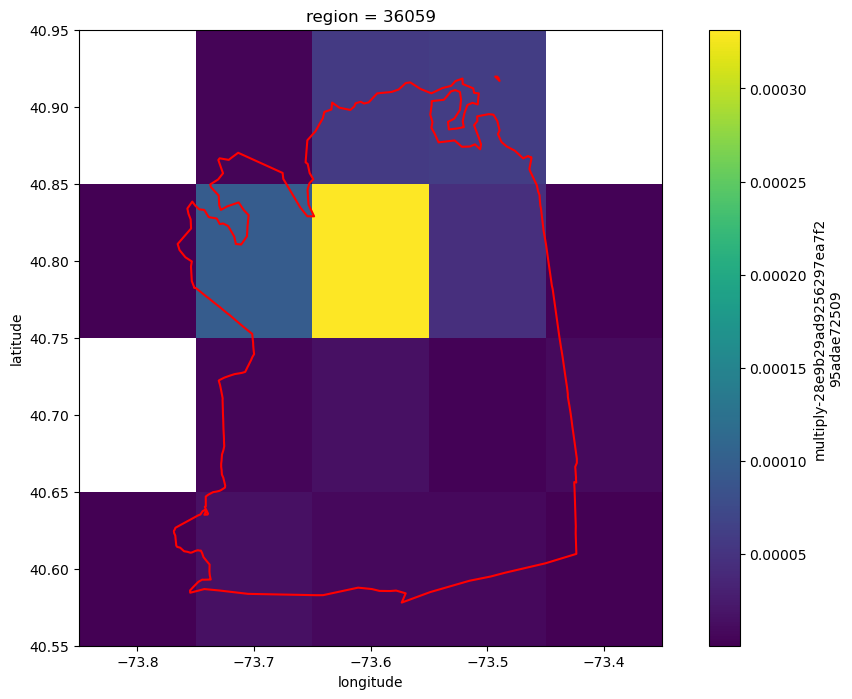

In [21]:
import matplotlib.pyplot as plt

nassau = w.sel(region='36059').compute()

fig, ax = plt.subplots(figsize=(12, 8))
(nassau
     # .rename({'lat':'latitude', 'lon':'longitude'})
     .where(nassau>0, drop = True).plot(ax = ax) )
georegions.plot_region('36059', ax=ax, color='red')

#### Run aggregation

In [34]:
def run_era5l_agg(year):
    # This function performs the actual aggregation for a single year, region.
    # Note that this function runs "lazily", i.e., returns an object that is
    # passed on to Dask for computation.
    
    # path = "/home3/dth2133/data/usa/usa-t2m_tempPrecLand1969.zarr"
    # Open climate dataset.
    clim = dataset.from_path(
        f"/home3/dth2133/data/usa/usa-t2m_tempPrecLand{year}.zarr", 
        't2m', 
        'zarr', 
        preprocess=dataset.timefix_era5l,
        name='era5') # Kelvin to Celsius
    
    # Clip climate data to the US (raw data are global)
    clim.clip_data_to_georegions_extent(georegions)
    # Rechunk dataset to optimize multithreading
    clim.rechunk('auto')
    
    # Collapse over time
    daily_list = [x.map_execute(clim) for x in daily]
    monthly_list = [monthly.map_execute(x, update=True) for x in daily_list]
    
    # Rechunk
    _ = [x.rechunk(-1) for x in monthly_list]
    
    # Spatial collapse
    spatial_list = [spatial.map_execute(x, w) for x in monthly_list]
    
    return [x.da.data for x in spatial_list]

In [35]:
print('AGGREGATING YEARS')
output_list = list()
time_list = list()
for year in years:
    print(year)

    # Start timing
    start = time.time()
    time_list.append(year)

    # Aggregate this year, region & append to list
    output_list.append(dask.compute(run_era5l_agg(year))[0])

    # Report timing
    stop = time.time()
    duration = stop-start
    print(round(duration/60,2))

AGGREGATING YEARS
2018
[########################################] | 100% Completed | 75.68 s
[########################################] | 100% Completed | 75.73 s
1.29


In [45]:
# len(output_list[0])
crop = 'corn'
project_dir = '/home3/dth2133/data/clim-data-compare/era5'
trange = np.arange(-4,41)
# yrange = np.arange(1951,2020)
yrange = np.arange(1951,2020)
yrange = yrange[yrange != 1959]

In [9]:
print('COMBINING OUTPUT')
# Put everything together in one dataset
d_list = list()
for t in range(len(temps)):
    y_list = list()
    for y in range(len(years)):
        # print(y)
        y_list.append(xr.DataArray(
            data = output_list[y][t],
            dims = ['region', 'year', 'month'],
            coords = dict(
                regioni=('region', georegions.regions),
                year = ('year', [years[y]]),
                month = ('month', np.arange(1,13))
            ),
            name = f'dday{temps[t]}'
        ))
    d_list.append(xr.concat(y_list, dim='year'))

COMBINING OUTPUT


In [10]:
ds = xr.combine_by_coords(d_list)

In [50]:
str(georegions.__dict__['shp'])

'      STATEFP COUNTYFP  COUNTYNS        AFFGEOID  GEOID       NAME LSAD  \\\n0          21      007  00516850  0500000US21007  21007    Ballard   06   \n1          21      017  00516855  0500000US21017  21017    Bourbon   06   \n2          21      031  00516862  0500000US21031  21031     Butler   06   \n3          21      065  00516879  0500000US21065  21065     Estill   06   \n4          21      069  00516881  0500000US21069  21069    Fleming   06   \n...       ...      ...       ...             ...    ...        ...  ...   \n3228       31      073  00835858  0500000US31073  31073     Gosper   06   \n3229       39      075  01074050  0500000US39075  39075     Holmes   06   \n3230       48      171  01383871  0500000US48171  48171  Gillespie   06   \n3231       55      079  01581100  0500000US55079  55079  Milwaukee   06   \n3232       26      139  01623012  0500000US26139  26139     Ottawa   06   \n\n           ALAND      AWATER  \\\n0      639387454    69473325   \n1      750439351 

In [41]:
# Save
ds.to_netcdf(f'/home3/dth2133/data/CIL_lads_demo.nc4')